# Import et préparation des fichiers des fichiers CSV

In [1]:
import pandas as pd
import numpy as np

Les données proviennent de la catégorie 'Bilans Alimentaires/ Nouveaux Bilans Alimentaire' de la FAO, avec les paramètres suivants :
- Sélection de tous les pays (Chine sans subdivisions)
- Eléments : 
    - Disponibilité alimentaire (Kcal/personne/jour)
    - Disponibilité de protéines en quantité (g/personne/jour)
- Produits : 
    - Produits Végétaux + (Total)
    - Produits Animaux + (Total)
- Années : 2017

L'import des données alimentaires a été effectué en séparant : 
- les produits d'origine végétale
- les produits d'origine animale

In [2]:
ani = pd.read_csv('p5_fao_ani.csv')
veg = pd.read_csv('p5_fao_veg.csv')

In [3]:
# Ajout de la colonne 'origine' dans chaque fichier
ani['origine'] = 'animale'
veg['origine'] = 'végétale'

# Fusion des deux fichiers
temp = ani.append(veg)

# Sélection des colonnes
temp = temp[['Code zone','Zone', 'Élément', 'Code Produit', 'Produit', 'Année', 'Unité', 'Valeur', 'origine']]

# Pivot du DF sur élément et origine

temp = temp.pivot_table(index=['Code zone','Zone','Année'], columns=['Élément', 'origine'], values='Valeur')
temp = temp.reset_index()

temp = temp.sort_values('Code zone')

Transformation du multi-index en flat index :

In [4]:
temp.columns = ["_".join(v) for v in temp.columns.values]

Changement de nom des colonnes :

In [5]:
temp.columns = ['code_country','country', 'year', 'food_avl_ani_kcal_p_d', 'food_avl_veg_kcal_p_d', 'prot_avl_ani_g_p_d', 'prot_avl_veg_g_p_d']

In [6]:
temp = temp[['code_country','country', 'year', 'food_avl_ani_kcal_p_d', 'food_avl_veg_kcal_p_d', 'prot_avl_ani_g_p_d', 'prot_avl_veg_g_p_d']]

Calculs :

In [7]:
# Proportion de protéines d'origine animale
temp['percent_prot_ani'] = temp['prot_avl_ani_g_p_d'] / (temp['prot_avl_ani_g_p_d'] + temp['prot_avl_veg_g_p_d'])

# total de la disponibilité alimentaire en kcal par habitant et par jour
temp['food_avl_kcal_p_d'] = temp['food_avl_ani_kcal_p_d'] + temp['food_avl_veg_kcal_p_d']

# total de la disponibilité alimentaire en protéine par habitant et par jour
temp['prot_avl_p_d'] = temp['prot_avl_ani_g_p_d'] + temp['prot_avl_veg_g_p_d']

Aperçu de DF 'temp' :

In [8]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 168
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   code_country           169 non-null    int64  
 1   country                169 non-null    object 
 2   year                   169 non-null    int64  
 3   food_avl_ani_kcal_p_d  169 non-null    float64
 4   food_avl_veg_kcal_p_d  169 non-null    float64
 5   prot_avl_ani_g_p_d     169 non-null    float64
 6   prot_avl_veg_g_p_d     169 non-null    float64
 7   percent_prot_ani       169 non-null    float64
 8   food_avl_kcal_p_d      169 non-null    float64
 9   prot_avl_p_d           169 non-null    float64
dtypes: float64(7), int64(2), object(1)
memory usage: 14.5+ KB


## Ajout du taux d'évolution de la population

Les données proviennent de la catégorie 'Séries temporelles annuelles' de la FAO, avec les paramètres suivants :

- Sélection de tous les pays (Chine sans subdivisions)
- Eléments : population totale
- Années : 2012 et 2017

J'ai choisi de sélectionner une différence de 5 ans afin de lisser des éventuelles fluctuations conjoncturelles

In [9]:
pop = pd.read_csv('p5_fao_pop2.csv')

In [10]:
pop = pop.pivot_table(index=['Code zone', 'Zone'], columns='Année', values='Valeur')
pop = pop.reset_index()

In [11]:
# Calcul du taux d'évolution
pop['pop_growth_rate'] = (pop[2017] - pop[2012]) / pop[2012]

In [12]:
# Changement de nom des colonnes
pop.columns = ['code_country', 'country', 'pop_1000_2012', 'pop_1000_2017', 'pop_growth_rate']

Aperçu du DF 'pop'

In [13]:
pop.head()

,code_country,country,pop_1000_2012,pop_1000_2017,pop_growth_rate
0,1,Arménie,2884.234,2944.791,0.020996
1,2,Afghanistan,31161.376,36296.113,0.164779
2,3,Albanie,2914.096,2884.169,-0.010270
3,4,Algérie,37383.895,41389.189,0.107140
4,5,Samoa américaines,55.667,55.620,-0.000844


In [14]:
# Changement de l'intitulé de deux pays, pour qu'ils soient identique à DF
pop.loc[pop['code_country'] == 229,'country'] = 'Royaume-Uni de Grande-Bretagne et d\'Irlande du Nord'
pop.loc[pop['code_country'] == 167,'country']  = 'Tchéquie'

In [15]:
pop['pop_1000_2017'].sum()
# Le nombre d'habitants correspond bien au total de ce site https://www.worldometers.info/world-population/#growthrate

7547858.925000001

## Jointure entre les deux DF

In [16]:
# Jointure interne avec temp à gauche
df = pd.merge(temp, pop, on=['code_country'])

In [17]:
df = df[['code_country','country_x', 'percent_prot_ani', 'food_avl_kcal_p_d', 'prot_avl_p_d', 'pop_growth_rate', 'pop_1000_2017']]

In [18]:
df.columns = ['code_country', 'country', 'percent_prot_ani', 'food_avl_kcal_p_d', 'prot_avl_p_d', 'pop_growth_rate', 'pop_1000_2017']

In [19]:
# Classement des pays par ordre alphabétique
df = df.sort_values('code_country')

Aperçu du DF 'df'

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 168
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_country       169 non-null    int64  
 1   country            169 non-null    object 
 2   percent_prot_ani   169 non-null    float64
 3   food_avl_kcal_p_d  169 non-null    float64
 4   prot_avl_p_d       169 non-null    float64
 5   pop_growth_rate    169 non-null    float64
 6   pop_1000_2017      169 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 10.6+ KB


In [21]:
# Sélection des colonnes
df = df[['country', 'percent_prot_ani', 'food_avl_kcal_p_d', 'prot_avl_p_d', 'pop_growth_rate']]

In [22]:
# vérification de la liste des pays après jointure
temp[~temp['country'].isin(df['country'])]

# Tous les pays sont biens compris dans le DF après jointure

,code_country,country,year,food_avl_ani_kcal_p_d,food_avl_veg_kcal_p_d,prot_avl_ani_g_p_d,prot_avl_veg_g_p_d,percent_prot_ani,food_avl_kcal_p_d,prot_avl_p_d


In [23]:
# vérification des pays qui n'apparaissent pas dans les bilans alimentaires

pop[~pop['country'].isin(df['country'])]

# Il en manque 63

,code_country,country,pop_1000_2012,pop_1000_2017,pop_growth_rate
4,5,Samoa américaines,55.667,55.620,-0.000844
5,6,Andorre,82.427,77.001,-0.065828
12,13,Bahreïn,1299.944,1494.076,0.149339
15,17,Bermudes,64.737,63.049,-0.026075
16,18,Bhoutan,701.581,745.563,0.062690
...,...,...,...,...,...
226,279,Curaçao,154.817,161.997,0.046377
227,280,Sint Maarten (partie néerlandaise),36.241,41.444,0.143567
228,281,Saint-Martin (partie française),37.009,36.560,-0.012132
229,282,Saint-Barthélemy,9.439,9.784,0.036550


In [24]:
# la variable 'country' est utilisé en index
df = df.set_index('country')

## Classement ascendant hiérarchique : dendrogramme

### Import des modules

In [25]:
from sklearn import decomposition
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

### Ajout de variables supplémentaires

#### Indicateur macro-économique : PIB par habitant

In [26]:
dfs = df
dfs = dfs[['percent_prot_ani', 'food_avl_kcal_p_d', 'prot_avl_p_d', 'pop_growth_rate']]
ind = pd.read_csv('p5_fao_ind.csv')
ind = ind[['Zone', 'Produit', 'Valeur']]
ind = ind.pivot_table(index='Zone', columns='Produit', values='Valeur')
ind = ind.reset_index()
ind.columns = ['country', 'PIB_hab']
dfs.info()
dfs = pd.merge(dfs,ind, on='country')
dfs = pd.merge(dfs,pop[['country','pop_1000_2017']],on='country')

<class 'pandas.core.frame.DataFrame'>
Index: 169 entries, Arménie to Chine
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   percent_prot_ani   169 non-null    float64
 1   food_avl_kcal_p_d  169 non-null    float64
 2   prot_avl_p_d       169 non-null    float64
 3   pop_growth_rate    169 non-null    float64
dtypes: float64(4)
memory usage: 6.6+ KB


### Indicateur de production : production de volaille

In [27]:
vol = pd.read_csv('p5_fao_vol.csv')

In [28]:
vol = vol[['Zone', 'Valeur']]
vol.columns = ['country', 'prod_vol']

In [29]:
dfs[~dfs['country'].isin(vol['country'])]

# Etant donné que l'objectif de l'entreprise est exporté de produire en France. J'accepte de perdre l'information sur ces deux pays qui sont géographiquement éloigné de la France

,country,percent_prot_ani,food_avl_kcal_p_d,prot_avl_p_d,pop_growth_rate,PIB_hab,pop_1000_2017
45,Djibouti,0.192383,2680.0,66.69,0.087500,2891.234525,944.099
90,Maldives,0.600759,2253.0,81.73,0.249637,10854.169233,496.402


In [30]:
dfs.info()
dfs = pd.merge(dfs,vol, on='country')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 168
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            169 non-null    object 
 1   percent_prot_ani   169 non-null    float64
 2   food_avl_kcal_p_d  169 non-null    float64
 3   prot_avl_p_d       169 non-null    float64
 4   pop_growth_rate    169 non-null    float64
 5   PIB_hab            169 non-null    float64
 6   pop_1000_2017      169 non-null    float64
dtypes: float64(6), object(1)
memory usage: 10.6+ KB


In [31]:
dfs.info()
# On note que l'on passe bien de 169 à 167 sans Djibouti et les Maldives

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167 entries, 0 to 166
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            167 non-null    object 
 1   percent_prot_ani   167 non-null    float64
 2   food_avl_kcal_p_d  167 non-null    float64
 3   prot_avl_p_d       167 non-null    float64
 4   pop_growth_rate    167 non-null    float64
 5   PIB_hab            167 non-null    float64
 6   pop_1000_2017      167 non-null    float64
 7   prod_vol           167 non-null    int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 11.7+ KB


In [32]:
dfs = dfs.set_index('country')

In [33]:
# Calcul du ratio
dfs['ratio_prod'] = dfs['prod_vol'] / dfs['pop_1000_2017'] 
# Sélection des colonnes
dfs = dfs[['percent_prot_ani', 'food_avl_kcal_p_d', 'prot_avl_p_d', 'pop_growth_rate', 'PIB_hab', 'ratio_prod']]
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, Arménie to Chine
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   percent_prot_ani   167 non-null    float64
 1   food_avl_kcal_p_d  167 non-null    float64
 2   prot_avl_p_d       167 non-null    float64
 3   pop_growth_rate    167 non-null    float64
 4   PIB_hab            167 non-null    float64
 5   ratio_prod         167 non-null    float64
dtypes: float64(6)
memory usage: 9.1+ KB


In [34]:
# Aperçu de 'dfs'
dfs.head()

,percent_prot_ani,food_avl_kcal_p_d,prot_avl_p_d,pop_growth_rate,PIB_hab,ratio_prod
country,,,,,,
Arménie,0.457692,3078.0,97.38,0.020996,3933.682101,3.599576
Afghanistan,0.195045,2000.0,54.09,0.164779,605.557362,0.758153
Albanie,0.554914,3399.0,119.55,-0.010270,4445.132198,4.476853
Algérie,0.276690,3349.0,92.92,0.107140,4051.244377,6.668746
Angola,0.304565,2270.0,54.11,0.187544,4100.291004,0.901204


In [35]:
# préparation des données pour le clustering
X = dfs.values # Extraction des valeurs
features = dfs.columns # Extraction des noms de variables
names = dfs.index # Extraction des noms de pays

In [36]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#### Création d'un Data Frame avec les valeurs centrées réduites (utile pour la présentation)

In [37]:
var = ['percent_prot_ani', 'food_avl_kcal_p_d', 'prot_avl_p_d', 'pop_growth_rate', 'PIB_hab', 'ratio_prod']
cent_red = pd.DataFrame({'country':dfs.index,var[0]:X_scaled[:,0], var[1]:X_scaled[:,1], var[2]:X_scaled[:,2], var[3]:X_scaled[:,3], var[4]:X_scaled[:,4], var[5]:X_scaled[:,5]})
cent_red 

,country,percent_prot_ani,food_avl_kcal_p_d,prot_avl_p_d,pop_growth_rate,PIB_hab,ratio_prod
0,Arménie,0.219210,0.479071,0.830685,-0.748934,-0.511060,-0.732973
1,Afghanistan,-1.453557,-1.889459,-1.346889,1.476802,-0.690449,-0.908644
2,Albanie,0.838412,1.184358,1.945880,-1.232921,-0.483493,-0.678736
3,Algérie,-0.933572,1.074500,0.606338,0.584555,-0.504724,-0.543222
4,Angola,-0.756038,-1.296228,-1.345883,1.829198,-0.502080,-0.899800
...,...,...,...,...,...,...,...
162,Luxembourg,1.351367,1.043740,1.266803,0.706363,5.206194,-0.927315
163,Serbie,0.393340,-0.122948,0.082694,-1.265252,-0.385032,-0.360222
164,Monténégro,1.164004,1.364524,1.631996,-1.033437,-0.306885,-0.595934
165,Soudan,-0.713240,-0.938092,-0.653224,0.901830,-0.558166,-0.852509


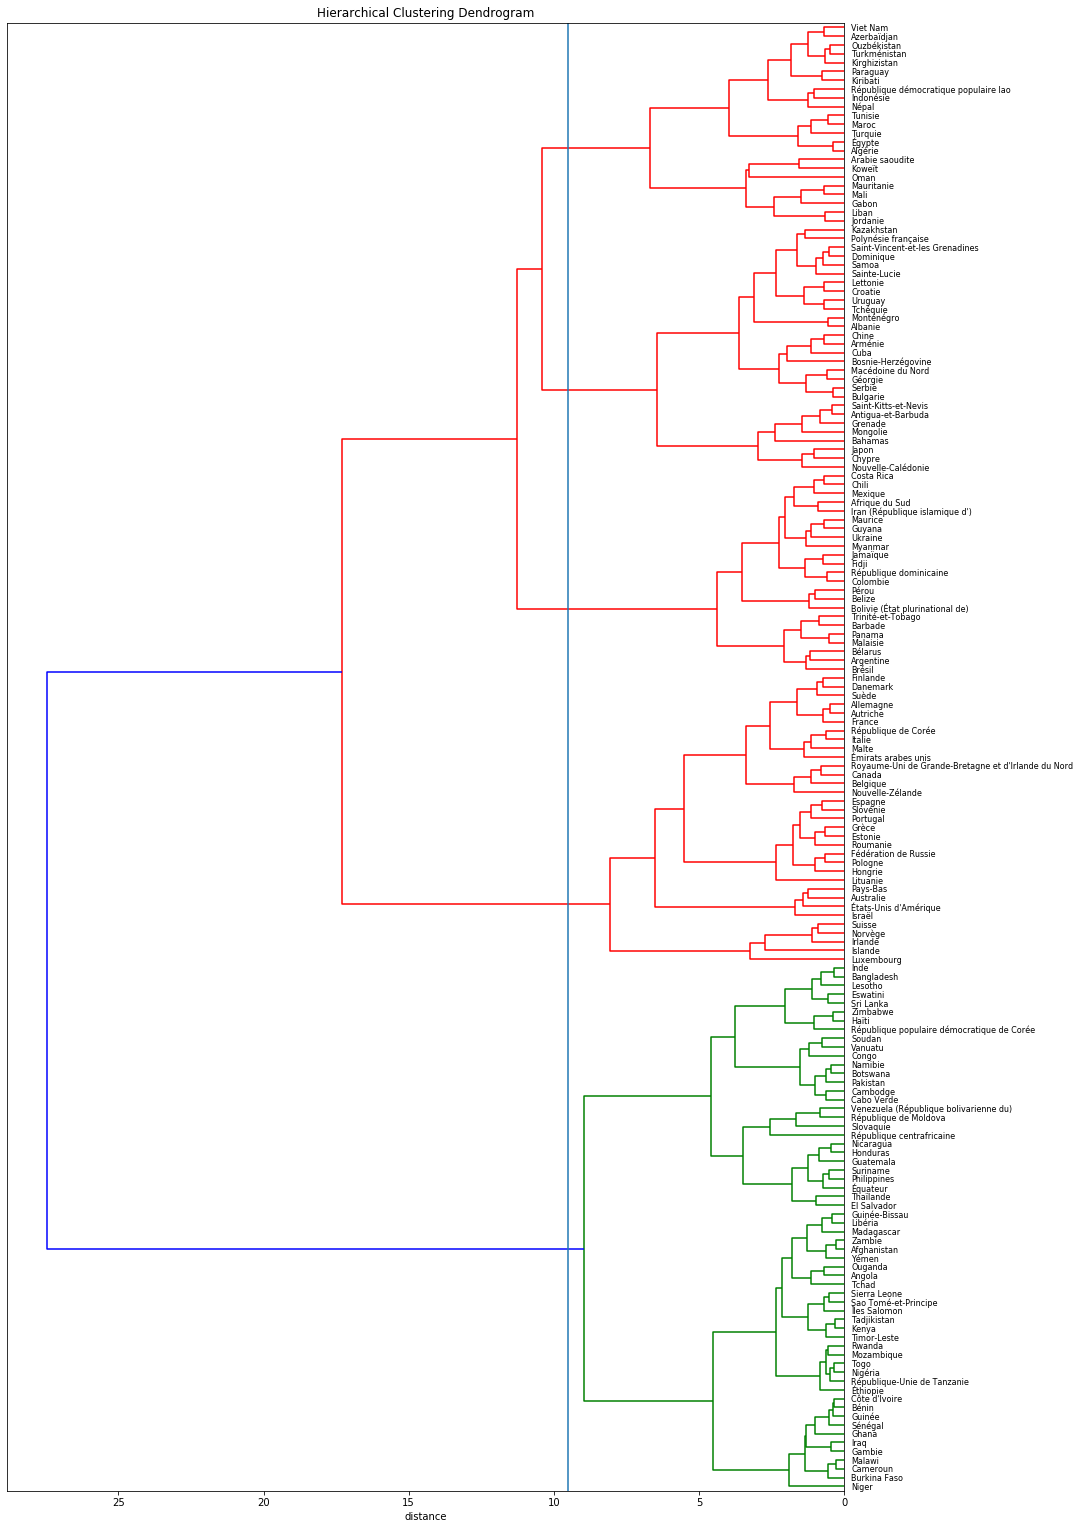

In [38]:
# Clustering hiérarchique (vue verticale)
Z = linkage(X_scaled, 'ward') # utilisation de la méthode de ward

plt.figure(figsize=(15,27))
plt.title('Hierarchical Clustering Dendrogram')
plt.axvline(9.5) # Traçage d'une ligne qui permet de diviser le dendrogramme en 5 clusters
plt.xlabel('distance')
dendrogram(
    Z,
    labels=names,
    leaf_font_size=8,
    leaf_rotation=0,
    orientation = "left",
)
plt.savefig('dendrogramme_1', bbox_inches = 'tight',
    pad_inches = 0.5)
plt.show()

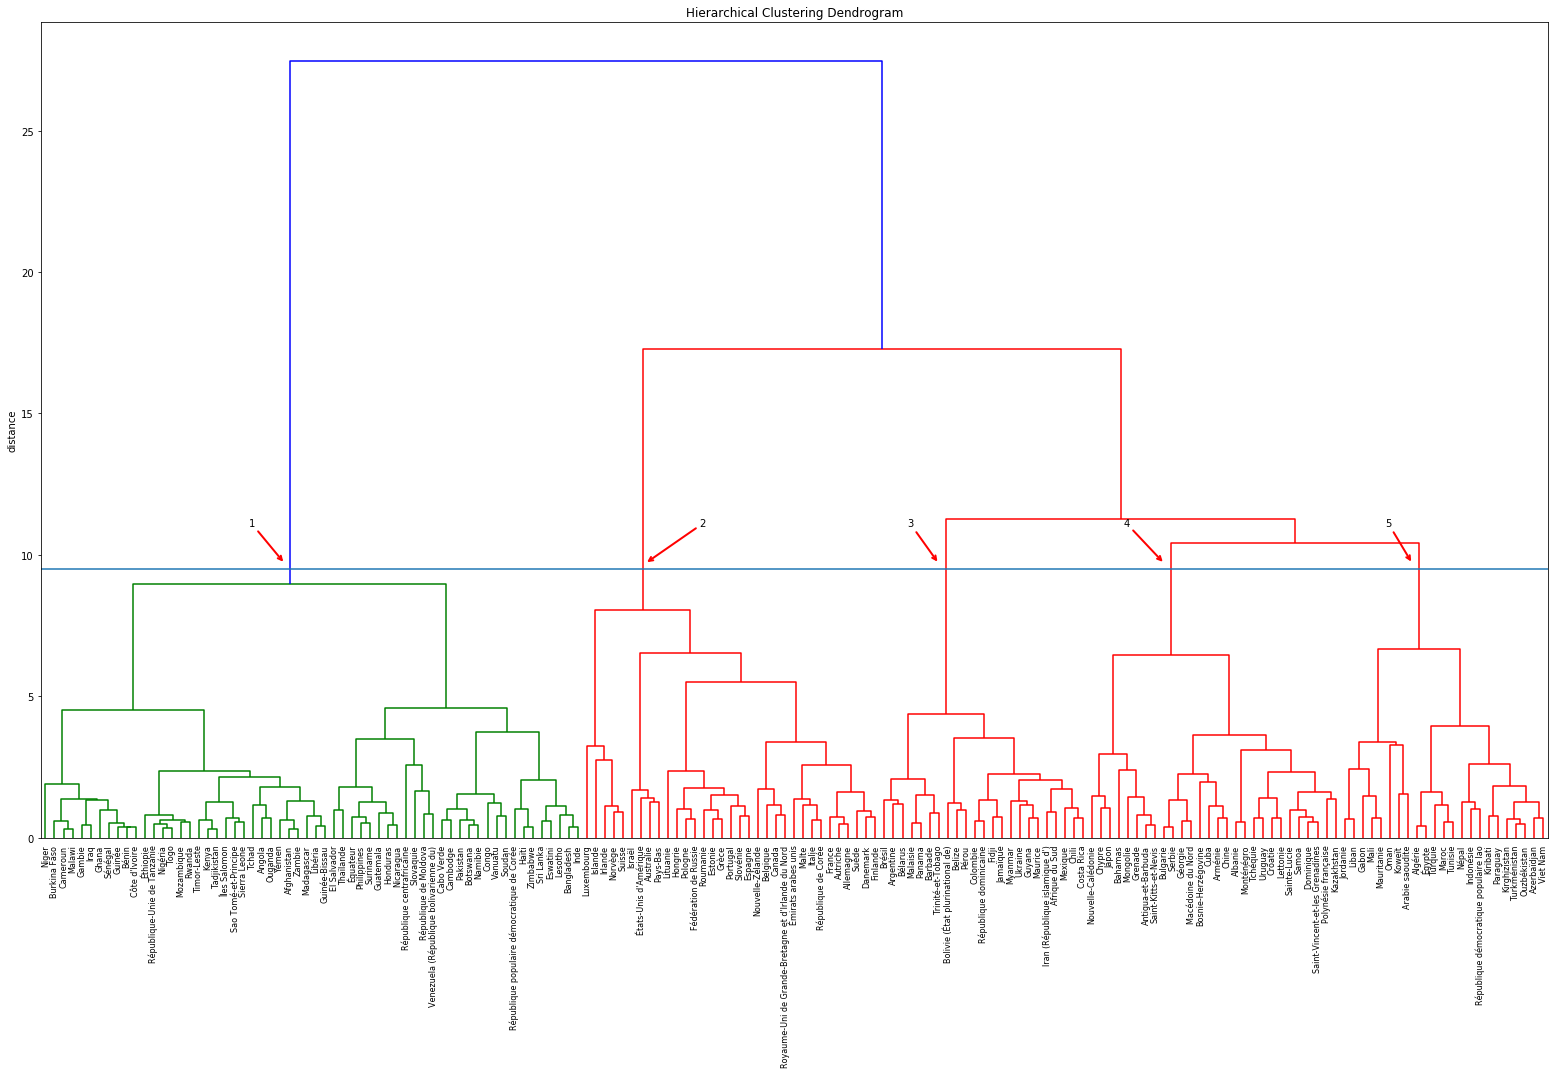

In [39]:
# Clustering hiérarchique (vue horizontale)

plt.figure(figsize=(27,15))
plt.title('Hierarchical Clustering Dendrogram')
plt.axhline(9.5)
plt.ylabel('distance')
dendrogram(
    Z,
    labels=names,
    leaf_font_size=8,
    leaf_rotation=90,
    orientation = "top",
)
plt
plt.annotate('1', xy=(270,9.7), xytext=(230,11),arrowprops=dict(arrowstyle='->', color='red', linewidth=2))
plt.annotate('2', xy=(670,9.7), xytext=(730,11),arrowprops=dict(arrowstyle='->', color='red', linewidth=2))
plt.annotate('3', xy=(995,9.7), xytext=(960,11),arrowprops=dict(arrowstyle='->', color='red', linewidth=2))
plt.annotate('4', xy=(1245,9.7), xytext=(1200,11),arrowprops=dict(arrowstyle='->', color='red', linewidth=2))
plt.annotate('5', xy=(1520,9.7), xytext=(1490,11),arrowprops=dict(arrowstyle='->', color='red', linewidth=2))

plt.savefig('dendrogramme_2', bbox_inches = 'tight',
    pad_inches = 0.5)
plt.show()

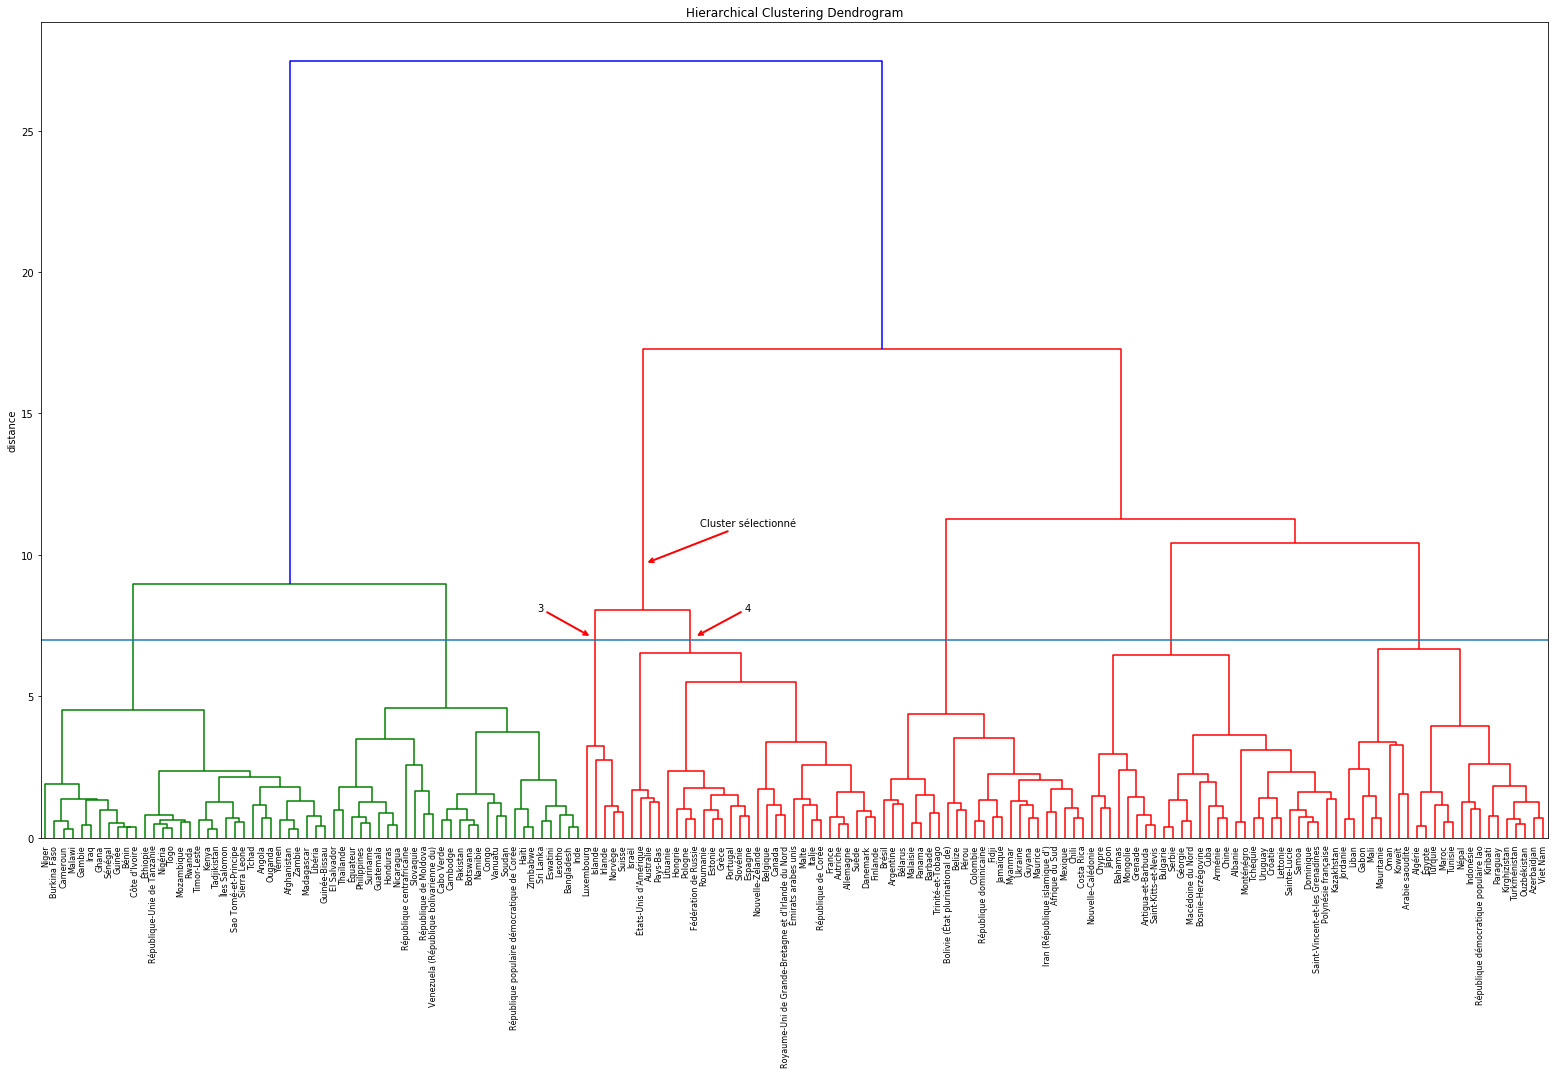

In [40]:
# Clustering hiérarchique (vue horizontale v2)
Z = linkage(X_scaled, 'ward')

plt.figure(figsize=(27,15))
plt.title('Hierarchical Clustering Dendrogram')
plt.axhline(7)
plt.ylabel('distance')
dendrogram(
    Z,
    labels=names,
    leaf_font_size=8,
    leaf_rotation=90,
    orientation = "top",
)

plt.annotate('Cluster sélectionné', xy=(670,9.7), xytext=(730,11),arrowprops=dict(arrowstyle='->', color='red', linewidth=2))
plt.annotate('3', xy=(610,7.1), xytext=(550,8),arrowprops=dict(arrowstyle='->', color='red', linewidth=2))
plt.annotate('4', xy=(725,7.1), xytext=(780,8),arrowprops=dict(arrowstyle='->', color='red', linewidth=2))

plt.savefig('dendrogramme_3', bbox_inches = 'tight',
    pad_inches = 0.5)
plt.show()

In [41]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [42]:
# nombre de composantes égale au nombre de variables utilisées
n_comp=6

In [43]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [44]:
# Coupage du dendrogramme en 5 clusters
clusters = fcluster(Z, 5, criterion='maxclust')

In [45]:
dfs['clusters'] = clusters

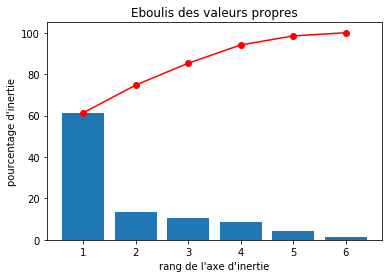

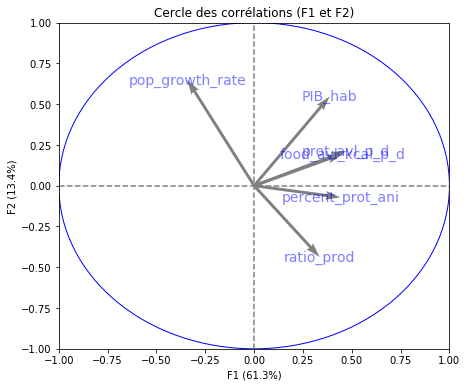

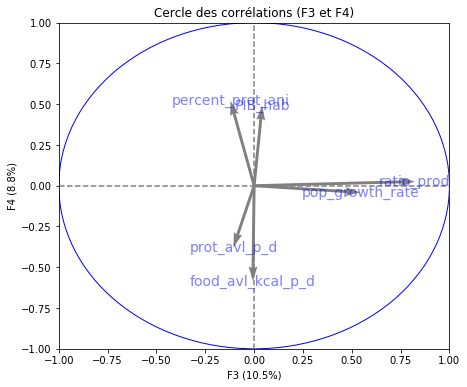

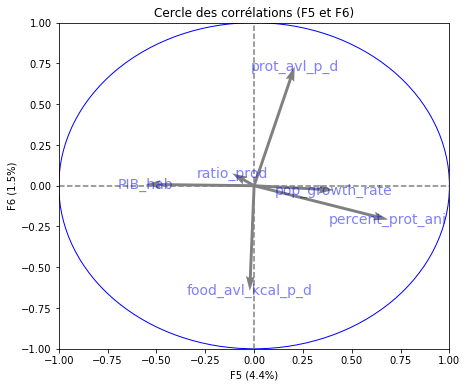

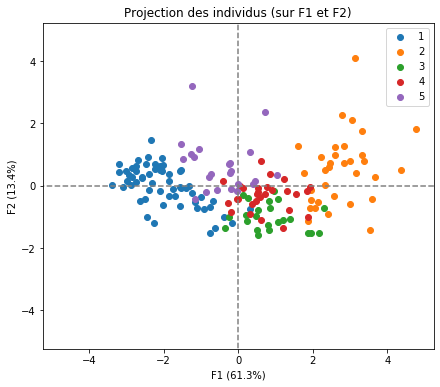

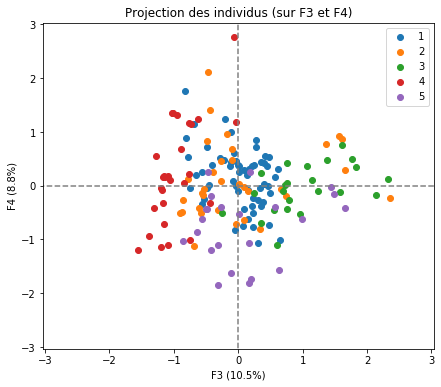

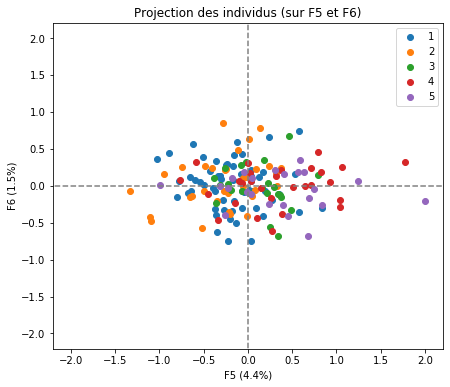

In [46]:
# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], illustrative_var=clusters)

plt.show()

## Combinaisons linéaires des axes d'inertie

### F1

In [47]:
F1 = pca.components_[0]
print(F1)

[ 0.44105303  0.45151618  0.47215798 -0.34204755  0.38643604  0.33517586]


### F2

In [48]:
F2 = pca.components_[1]
print(F2)

[-0.07125824  0.19412221  0.21336052  0.64905839  0.54729755 -0.43692644]


In [49]:
# Résumé des deux premiers axes d'inertie dans un date frame
var = ['percent_prot_ani', 'food_avl_kcal_p_d', 'prot_avl_p_d', 'pop_growth_rate', 'PIB_hab', 'ratio_prod']
combi_lin = pd.DataFrame({'Variables':var,'F1':F1, 'F2':F2})
combi_lin = combi_lin.set_index('Variables')
combi_lin

,F1,F2
Variables,,
percent_prot_ani,0.441053,-0.071258
food_avl_kcal_p_d,0.451516,0.194122
prot_avl_p_d,0.472158,0.213361
pop_growth_rate,-0.342048,0.649058
PIB_hab,0.386436,0.547298
ratio_prod,0.335176,-0.436926


### Aperçu des 7 premiers pays (par ordre alphabétique) de chaque cluster

In [50]:
dfs[dfs["clusters"] == 1].head(7)

,percent_prot_ani,food_avl_kcal_p_d,prot_avl_p_d,pop_growth_rate,PIB_hab,ratio_prod,clusters
country,,,,,,,
Afghanistan,0.195045,2000.0,54.09,0.164779,605.557362,0.758153,1
Angola,0.304565,2270.0,54.11,0.187544,4100.291004,0.901204,1
Bangladesh,0.198375,2596.0,60.29,0.057479,1491.673410,1.217569,1
Botswana,0.405799,2340.0,65.18,0.081157,7595.147598,2.086092,1
Îles Salomon,0.295565,2411.0,53.66,0.143825,1961.155429,0.462236,1
Cameroun,0.162131,2653.0,69.45,0.143392,1455.460927,3.112870,1
Cabo Verde,0.370637,2515.0,69.34,0.063857,3239.065521,1.838146,1


In [51]:
dfs[dfs["clusters"] == 2].head(7)

,percent_prot_ani,food_avl_kcal_p_d,prot_avl_p_d,pop_growth_rate,PIB_hab,ratio_prod,clusters
country,,,,,,,
Australie,0.659574,3311.0,108.10,0.073379,57917.093685,50.011145,2
Autriche,0.600018,3693.0,108.13,0.037364,47887.174380,14.421931,2
Canada,0.503656,3492.0,101.20,0.051832,45057.287226,33.682342,2
Danemark,0.647824,3384.0,113.04,0.021631,57454.289221,26.466285,2
Estonie,0.572000,3245.0,107.50,-0.002848,20508.891852,15.461691,2
Finlande,0.624384,3337.0,117.78,0.017840,46180.408610,21.918321,2
France,0.621643,3558.0,112.09,0.020110,38566.566085,17.916410,2


In [52]:
dfs[dfs["clusters"] == 3].head(7)

,percent_prot_ani,food_avl_kcal_p_d,prot_avl_p_d,pop_growth_rate,PIB_hab,ratio_prod,clusters
country,,,,,,,
Argentine,0.639630,3238.0,102.70,0.052256,14517.291248,48.159712,3
Barbade,0.564370,2896.0,89.25,0.008921,17423.251128,55.217446,3
Bolivie (État plurinational de),0.453762,2353.0,68.45,0.078551,3393.959523,45.037035,3
Brésil,0.581114,3249.0,90.86,0.042885,9812.310980,65.472269,3
Belize,0.378833,2699.0,67.18,0.111743,4901.752333,52.282120,3
Myanmar,0.478522,2700.0,93.35,0.038294,1245.826398,28.099084,3
Chili,0.513712,3011.0,88.61,0.061498,15383.587714,33.898869,3


In [53]:
dfs[dfs["clusters"] == 4].head(7)

,percent_prot_ani,food_avl_kcal_p_d,prot_avl_p_d,pop_growth_rate,PIB_hab,ratio_prod,clusters
country,,,,,,,
Arménie,0.457692,3078.0,97.38,0.020996,3933.682101,3.599576,4
Albanie,0.554914,3399.0,119.55,-0.010270,4445.132198,4.476853,4
Antigua-et-Barbuda,0.663720,2430.0,81.45,0.055492,14390.246028,1.006015,4
Bahamas,0.683423,2043.0,61.47,0.049977,30732.419232,18.412333,4
Bulgarie,0.499760,2828.0,83.34,-0.031573,8321.113046,12.253388,4
Cuba,0.368385,3410.0,88.44,0.007298,8433.092699,2.579535,4
Chypre,0.568635,2616.0,80.28,0.039322,26473.007605,21.276993,4


In [54]:
dfs[dfs["clusters"] == 5].head(7)

,percent_prot_ani,food_avl_kcal_p_d,prot_avl_p_d,pop_growth_rate,PIB_hab,ratio_prod,clusters
country,,,,,,,
Algérie,0.276690,3349.0,92.92,0.107140,4051.244377,6.668746,5
Azerbaïdjan,0.326042,3103.0,92.35,0.062671,4158.357869,10.600163,5
Égypte,0.249974,3321.0,96.33,0.115946,2000.297246,10.821101,5
Gabon,0.486758,2643.0,79.67,0.180113,7372.081131,1.888782,5
Kiribati,0.499256,3057.0,73.91,0.073216,1594.344097,7.507139,5
Indonésie,0.323281,2892.0,68.64,0.065201,3846.426581,8.532895,5
Jordanie,0.349154,2714.0,69.11,0.209628,4195.802289,19.669639,5


## Boîtes à moustaches des groupes sur chaque variable

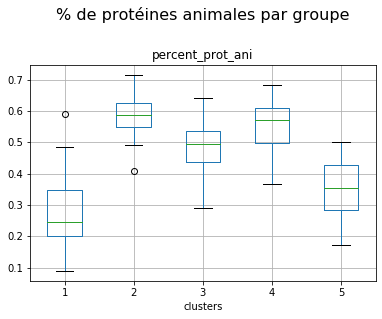

In [55]:
dfs.boxplot(column='percent_prot_ani', by='clusters')
plt.suptitle('% de protéines animales par groupe', size=16, y=1.1)
plt.xlabel('clusters')
plt.savefig('box_plot_var1', bbox_inches = 'tight', pad_inches = 0.5)
plt.show()

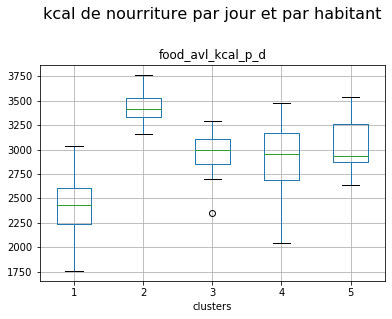

In [56]:
dfs.boxplot(column='food_avl_kcal_p_d', by='clusters')
plt.suptitle('kcal de nourriture par jour et par habitant', size=16, y=1.1)
plt.xlabel('clusters')
plt.savefig('box_plot_var2', bbox_inches = 'tight', pad_inches = 0.5)
plt.show()

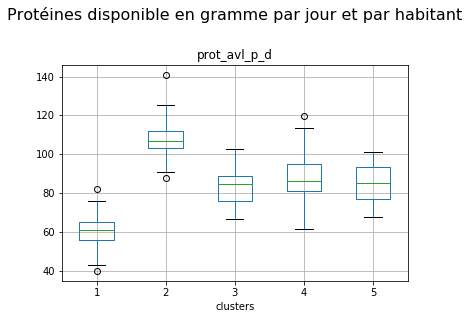

In [57]:
dfs.boxplot(column='prot_avl_p_d', by='clusters')
plt.suptitle('Protéines disponible en gramme par jour et par habitant', size=16, y=1.1)
plt.xlabel('clusters')
plt.savefig('box_plot_var3', bbox_inches = 'tight', pad_inches = 0.5)
plt.show()

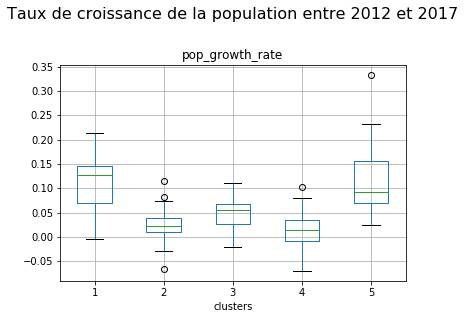

In [58]:
dfs.boxplot(column='pop_growth_rate', by='clusters')
plt.suptitle('Taux de croissance de la population entre 2012 et 2017', size=16, y=1.1)
plt.xlabel('clusters')
plt.savefig('box_plot_var4', bbox_inches = 'tight', pad_inches = 0.5)
plt.show()

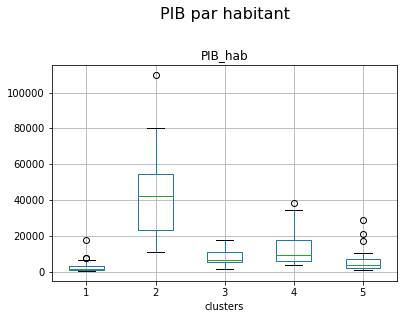

In [59]:
dfs.boxplot(column='PIB_hab', by='clusters')
plt.suptitle('PIB par habitant', size=16, y=1.1)
plt.xlabel('clusters')
plt.savefig('box_plot_var5', bbox_inches = 'tight', pad_inches = 0.5)
plt.show()

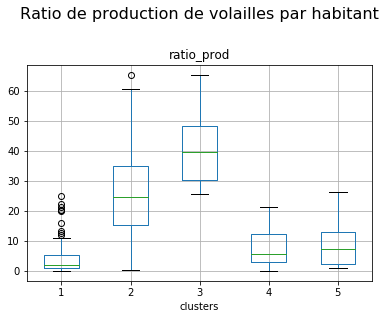

In [60]:
dfs.boxplot(column='ratio_prod', by='clusters')
plt.suptitle('Ratio de production de volailles par habitant', size=16, y=1.1)
plt.xlabel('clusters')
plt.savefig('box_plot_var6', bbox_inches = 'tight', pad_inches = 0.5)
plt.show()

## Affichage des centroïdes

In [61]:
def display_factorial_planes2(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                    plt.scatter(X_projected[selected, d1].mean(), X_projected[selected, d2].mean(), alpha=alpha, marker='s',linewidths=3, c='black') 
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            
            plt.show(block=False)

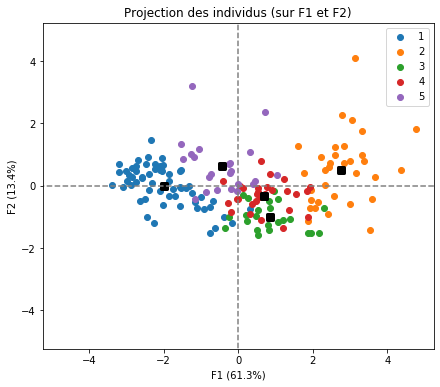

In [62]:
display_factorial_planes2(X_projected, n_comp, pca, [(0,1)], illustrative_var=clusters)

In [63]:
dfs['F1'] = X_projected[:,0]
dfs['F2'] = X_projected[:,1]

## Caractérisation des clusters

In [64]:
resume = dfs.groupby('clusters').mean()

In [65]:
resume = resume.append(dfs.describe().loc['mean'])

In [66]:
resume = resume.drop('clusters', axis=1)
resume

,percent_prot_ani,food_avl_kcal_p_d,prot_avl_p_d,pop_growth_rate,PIB_hab,ratio_prod,F1,F2
clusters,,,,,,,,
1,0.277152,2412.750000,60.365333,0.108944,2407.636014,5.188151,-1.992546e+00,5.711389e-03
2,0.585148,3433.151515,107.667576,0.023498,42241.754394,27.574467,2.754399e+00,5.206953e-01
3,0.482432,2960.130435,83.049565,0.047588,8495.746651,40.377523,8.467638e-01,-9.979566e-01
4,0.548620,2910.714286,87.598214,0.015136,12963.225831,8.100017,6.877177e-01,-3.226121e-01
5,0.360445,3042.217391,85.512609,0.119809,6240.039620,8.882178,-4.380042e-01,6.287179e-01
mean,0.423273,2859.958084,80.866048,0.069377,13415.146487,15.455210,-2.792178e-17,4.541444e-17


### Création d'un tableau sous forme 'heatmap'

In [67]:
# Utilisation des données centrées et réduites
cent_red = pd.merge(cent_red, dfs[['clusters']], on='country')

In [68]:
cent_red_mean = cent_red.groupby('clusters').mean()

In [69]:
import seaborn as sns

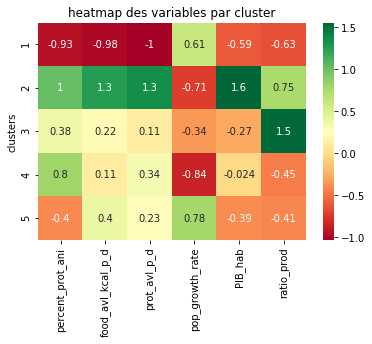

In [70]:
sns.heatmap(cent_red_mean,annot=True,cmap='RdYlGn')
plt.title('heatmap des variables par cluster')
plt.savefig('heatmap', bbox_inches = 'tight', pad_inches = 0.5)

## Sélection d'un cluster

In [71]:
# Coupage du dendrogramme en 7 clusters
clusters2 = fcluster(Z, 7, criterion='maxclust')
dfs2 = dfs
dfs2['clusters2'] = clusters2

In [72]:
dfs2 = dfs2[['percent_prot_ani', 'food_avl_kcal_p_d', 'prot_avl_p_d', 'pop_growth_rate', 'PIB_hab', 'ratio_prod', 'clusters2']]

In [73]:
dfs2.groupby('clusters2').mean()

,percent_prot_ani,food_avl_kcal_p_d,prot_avl_p_d,pop_growth_rate,PIB_hab,ratio_prod
clusters2,,,,,,
1,0.211098,2381.125000,58.867187,0.147543,1231.008372,2.081153
2,0.352641,2448.892857,62.077500,0.064830,3752.353320,8.739006
3,0.623852,3495.600000,111.750000,0.057124,81783.457453,15.287540
4,0.578237,3422.000000,106.938571,0.017493,35180.735991,29.768561
5,0.482432,2960.130435,83.049565,0.047588,8495.746651,40.377523
6,0.548620,2910.714286,87.598214,0.015136,12963.225831,8.100017
7,0.360445,3042.217391,85.512609,0.119809,6240.039620,8.882178


In [74]:
dfs2.groupby('clusters2').mean().loc[3:4,"percent_prot_ani":"ratio_prod"]

,percent_prot_ani,food_avl_kcal_p_d,prot_avl_p_d,pop_growth_rate,PIB_hab,ratio_prod
clusters2,,,,,,
3,0.623852,3495.6,111.750000,0.057124,81783.457453,15.287540
4,0.578237,3422.0,106.938571,0.017493,35180.735991,29.768561


### Création d'une deuxiéme heatmap

In [75]:
cent_red2 = pd.merge(cent_red, dfs2[['clusters2']], on='country')
cent_red_mean2 = cent_red2.groupby('clusters2').mean()

In [76]:
cent_red_mean2 = cent_red_mean2.loc[3:4,"percent_prot_ani":"ratio_prod"]

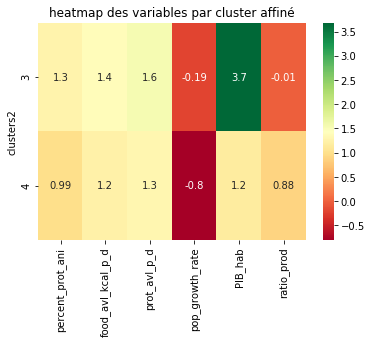

In [77]:
sns.heatmap(cent_red_mean2,annot=True,cmap='RdYlGn')
plt.title('heatmap des variables par cluster affiné')
plt.savefig('heatmap2', bbox_inches = 'tight', pad_inches = 0.5)

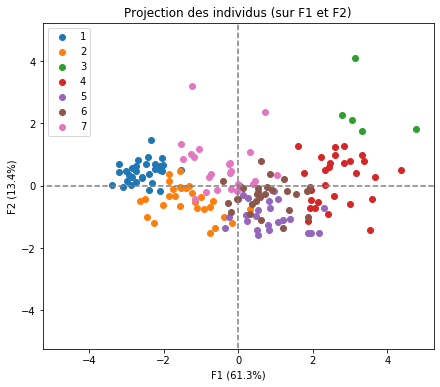

In [78]:
# Affichage des nouveaux clusters sur le premier plan factoriel
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=clusters2)

In [79]:
# Affichage de mon cluster final
dfs2[dfs2['clusters2'] == 3]

,percent_prot_ani,food_avl_kcal_p_d,prot_avl_p_d,pop_growth_rate,PIB_hab,ratio_prod,clusters2
country,,,,,,,
Islande,0.715694,3627.0,141.01,0.026842,73108.083207,28.998813,3
Irlande,0.570458,3717.0,105.95,0.031483,70492.921726,19.155829,3
Norvège,0.585603,3385.0,110.16,0.056369,75092.402428,17.171148,3
Suisse,0.612053,3414.0,95.58,0.055918,80220.632483,10.655758,3
Luxembourg,0.635455,3335.0,106.05,0.115008,110003.247419,0.456150,3


### Ajout de la population

In [80]:
dfs3 = pd.merge(dfs2[dfs2['clusters2'] == 3],pop[['country','pop_1000_2017']], on='country')

In [81]:
dfs3 = dfs3.set_index('country')

In [82]:
dfs3

,percent_prot_ani,food_avl_kcal_p_d,prot_avl_p_d,pop_growth_rate,PIB_hab,ratio_prod,clusters2,pop_1000_2017
country,,,,,,,,
Islande,0.715694,3627.0,141.01,0.026842,73108.083207,28.998813,3,334.393
Irlande,0.570458,3717.0,105.95,0.031483,70492.921726,19.155829,3,4753.279
Norvège,0.585603,3385.0,110.16,0.056369,75092.402428,17.171148,3,5296.326
Suisse,0.612053,3414.0,95.58,0.055918,80220.632483,10.655758,3,8455.804
Luxembourg,0.635455,3335.0,106.05,0.115008,110003.247419,0.456150,3,591.910


In [83]:
# Nombre total d'habitant dans le cluster retenu 
dfs3['pop_1000_2017'].sum() * 1000

19431712.0

# Livrables

In [84]:
list_coutnry = dfs[['clusters', 'clusters2']]
list_coutnry.to_csv('P5_03_liste_des_pays.csv')

In [85]:
list_clusters = dfs

In [86]:
list_clusters['F1'] = X_projected[:,0]
list_clusters['F2'] = X_projected[:,1]
list_clusters['F3'] = X_projected[:,2]
list_clusters['F4'] = X_projected[:,3]
list_clusters['F5'] = X_projected[:,4]
list_clusters['F6'] = X_projected[:,5]

In [87]:
list_clusters = list_clusters.groupby('clusters').mean()
list_clusters = list_clusters[['percent_prot_ani', 'food_avl_kcal_p_d', 'prot_avl_p_d', 'pop_growth_rate', 'PIB_hab', 'ratio_prod', 'F1', 'F2', 'F3', 'F4','F5','F6']]

In [93]:
list_clusters.to_csv('P5_04_liste_des_clusters.csv')

# Test d'adéquation

In [89]:
import statsmodels.api as sm
from scipy import stats as sp

## Boucle sur chaque variable étudiée : histogramme, QQ-plot et test de Shapiro-Wilk

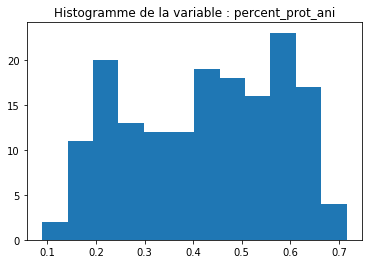

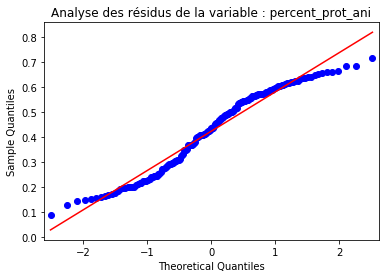

Test de Shapiro :
(0.9551877975463867, 3.5172761272406206e-05)






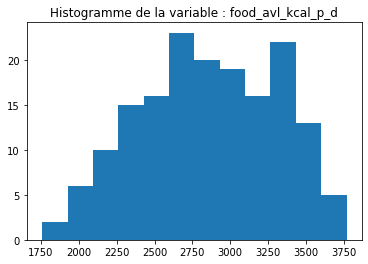

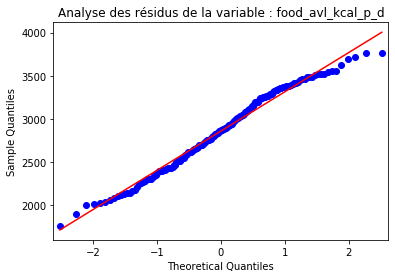

Test de Shapiro :
(0.9810149669647217, 0.021837100386619568)






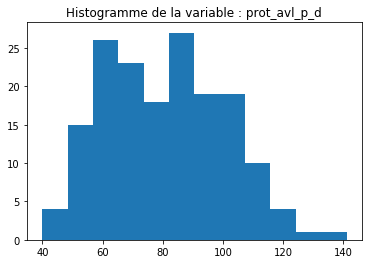

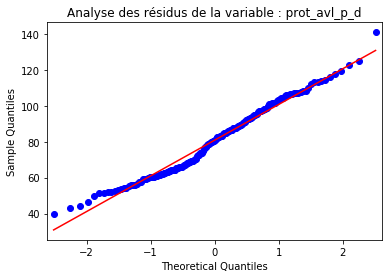

Test de Shapiro :
(0.9789448976516724, 0.012125125154852867)






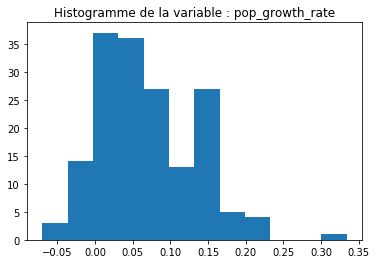

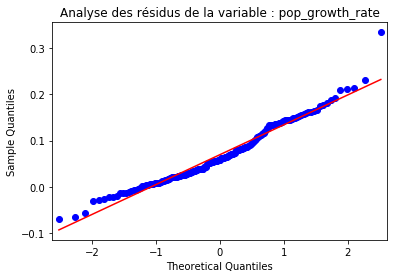

Test de Shapiro :
(0.9676260352134705, 0.0006105420179665089)






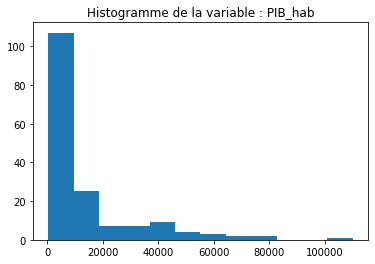

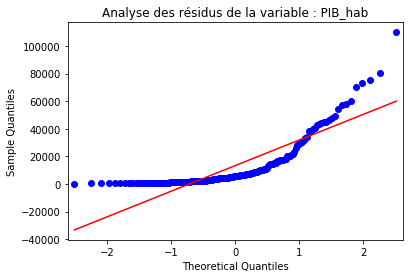

Test de Shapiro :
(0.6954981088638306, 3.604655247903572e-17)






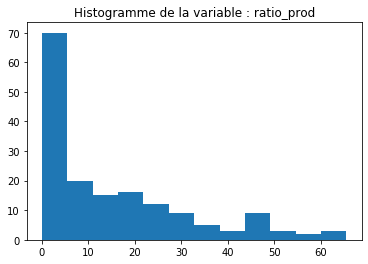

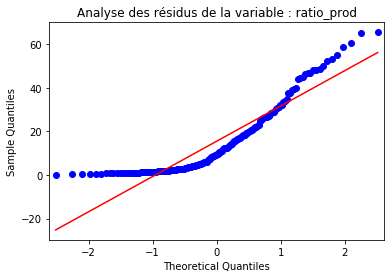

Test de Shapiro :
(0.838914155960083, 2.7517072821725552e-12)






In [90]:
for i in range(0,6):
    plt.hist(dfs[dfs.columns[i]], bins=12)
    plt.title('Histogramme de la variable : ' + dfs.columns[i])
    sm.qqplot(dfs[dfs.columns[i]], dist='norm',line='s')
    plt.title('Analyse des résidus de la variable : ' + dfs.columns[i])
    plt.show()
    print('Test de Shapiro :')
    print(sp.shapiro(dfs[dfs.columns[i]]))
    print('\n')
    print('\n')

La variable 'food_avl_kcal_p_d' se rapproche le plus d'une distribution normale

## Test de comparaison

In [91]:
# Comparaison des variances
sp.bartlett(dfs[dfs['clusters'] == 2]['food_avl_kcal_p_d'],dfs[dfs['clusters'] == 3]['food_avl_kcal_p_d'])

BartlettResult(statistic=2.542804463812747, pvalue=0.11079783241343152)

On rejette l'hypothèse d'égalité des variances

In [92]:
# Comparaison des moyennes
sp.ttest_ind(dfs[dfs['clusters'] == 2]['food_avl_kcal_p_d'], dfs[dfs['clusters'] == 3]['food_avl_kcal_p_d'], equal_var=True)

Ttest_indResult(statistic=9.28130366695296, pvalue=8.95176229499032e-13)

On rejette l'hypothèse d'égalité des moyennes